# Fase de exploración y análisis de los datos
El conjunto de datos sobre el que se articula el estudio planteado proviene de la competición [IberLEF 2023 Task PoliticEs. Political ideology detection in Spanish texts](https://codalab.lisn.upsaclay.fr/competitions/10173). Este dataset es una extensión de PoliCorpus 2020 dataset (García-Díaz et al. 2022a) y el empleado para la edición anterior de este mismo concurso IberLEF 2022 Task PoliticEs. Spanish Author Profiling for Political Ideology. El dataset se compone de una recopilación de tweets publicados entre 2020 y 2022 por cuentas de twitter pertenecientes a políticos, periodistas y diferentes celebridades Españolas empleando la herramienta UMUCorpusClasifier.

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("../data/politicES_phase_1_traindev_public.csv")
df.head()

,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,"@user Escribió un libro resultón, con gracejo,..."
1,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,@user Lo prometido es deuda. Aquí la foto: .
2,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,@user Bastante ñoña. Me jarté a llorar. De lo ...
3,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,"@user No sé nada acerca de eso, pero está clar..."
4,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,"@user ¿En qué medio tienen su podcast esos, di..."


El conjunto de datos está correctamente etiquetado, con las etiquetas binaria y multiclase. El principal objetivo del tratamiento de los datos será el de realizar predicciones sobre una de estas dos variables, por lo que el resto de ellas son prescindibles. Antes de proceder a eliminarlas, se elaborarán algunos gráficos informativos para entender mejor los datos con los que se trabaja.

## Análisis exploratorio

### Variables categóricas

En primer lugar, se realiza un análisis detallado de la distribución de las diferentes variables contenidas en el conjunto de datos


In [5]:
# df = df.drop(["label"], axis = 1)
dist = pd.DataFrame({})
for column in ["gender", "profession", "ideology_binary", "ideology_multiclass"]:
    for value in df[column].unique():
        count = np.sum(df[column] == value)
        entry = pd.DataFrame({
            "column": column,
            "value": value,
            "count": count,
            "%": count / df[column].count() 
        }, index= [0])
        dist = pd.concat([dist, entry]).reset_index(drop=True)  
dist

,column,value,count,%
0,gender,male,9800,0.680556
1,gender,female,4600,0.319444
2,profession,journalist,8640,0.600000
3,profession,celebrity,960,0.066667
4,profession,politician,4800,0.333333
5,ideology_binary,left,8000,0.555556
6,ideology_binary,right,6400,0.444444
7,ideology_multiclass,left,2760,0.191667
8,ideology_multiclass,right,1680,0.116667
9,ideology_multiclass,moderate_right,4720,0.327778


Del análisis general de la distribución de las diferentes variables, es posible sacar algunas conclusiones:
- Existe un sesgo de género altamente notable en el conjunto de datos: El __68% de los tweets__ pertenecen a autores de __género masculino__. 
- El 60% de los tweets pertenecen a __periodistas__. 
- El balance entre las ideologías se inclina ligeramente hacia la izquierda: El 55% de los tweets recogidos en el dataset han sido etiquetados como pertenecientes a la izquierda.
- La variable de ideología multiclase se distribuye de manera que las ideologías moderadas componen el grosso del conjunto, mientras que las categorías extremistas (etiquetadas como "left" y "right") abarcan el 30% de los tweets. 

### Variable principal `tweet`

Para proceder con el análisis de la variable principal del dataset, la que contiene los tweets que se pretenden procesar, se procederá en primer lugar analizando las características lingüísticas de los textos para las diferentes categorías que permiten diferenciar las diferentes variables.

> Es necesario para el análisis de las características lingüísticas de la variable tweet realizar algunas acciones previas de preprocesamiento como la tokenización y la lematización.

En primer lugar, se procederá a eliminar los saltos de línea, dobles espacios, tabulaciones y otros caracteres indeseados para esta fase. 

In [6]:
import re
def replace_characters(t):
    s = t.replace('\r\n', ' ')
    s = s.replace('\n\n', ' ')
    s = s.replace('\n', ' ')
    s = s.replace('\r', ' ')
    return re.sub('\s\s+', ' ', s)
df["tweet_clean"] = df["tweet"].apply(replace_characters)

In [7]:
import spacy
nlp = spacy.load("es_core_news_md")
def clear_stopwords(tweet):
    return " ".join([token.text.lower() for token in nlp(tweet) 
                     if not token.is_stop
                     and not token.is_punct
                     and not token.text.lower() in ["@user","political_party", "politician", "hashtag", "user"]
                    ])
df["tweet_clean"] = df["tweet"].apply(clear_stopwords)

#### Tweets por género

##### Masculino

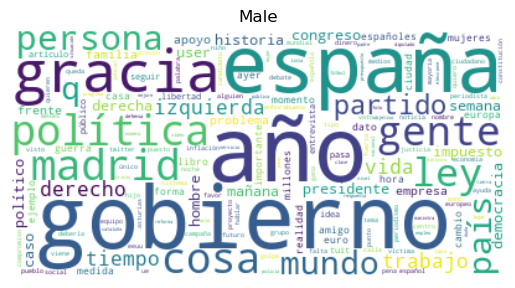

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import textstat
import functools
textstat.set_lang('es')

stats = [textstat.fernandez_huerta,textstat.szigriszt_pazos, textstat.gutierrez_polini, textstat.crawford, textstat.reading_time]
stats_name = ["Fernandez Huerta", "Szigriszt Pazos", "Gutierrez Polini", "Crawford", "Tiempo de lectura"]
df_stats_tweets = pd.DataFrame({})

def show_word_cloud(words, title):
    wordcloud = WordCloud(background_color='white').generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

male = " ".join(df[df["gender"] == "male"]["tweet_clean"])
show_word_cloud(male, "Male")

In [9]:
from collections import Counter
Counter(male.split()).most_common(10)

[('gobierno', 668),
 ('españa', 564),
 ('años', 477),
 ('👇', 464),
 ('gracias', 382),
 ('ley', 332),
 ('madrid', 289),
 ('gente', 259),
 ('país', 243),
 ('año', 238)]

In [63]:
male_tweets = df[df["gender"] == "male"]["tweet"]
male_stats = {"Group": "Male"}
for func, name in zip(stats, stats_name):
    male_stats[name] = np.sum(male_tweets.apply(lambda x: func(x)) / len(male_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(male_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

,Group,Fernandez Huerta,Szigriszt Pazos,Gutierrez Polini,Crawford,Tiempo de lectura
0,Male,78.210451,74.330711,43.963551,4.138418,2.061668
1,Male,78.210451,74.330711,43.963551,4.138418,2.061668
2,Female,78.203335,74.287509,43.927387,4.125435,2.076802


##### Femenino

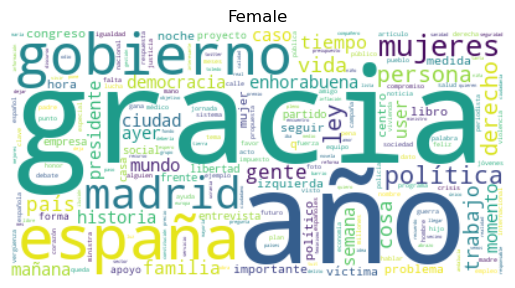

In [25]:
female = " ".join(df[df["gender"] == "female"]["tweet_clean"])
show_word_cloud(female, "Female")

In [15]:
female = " ".join(df[df["gender"] == "female"]["tweet_clean"])
Counter(female.split()).most_common(10)

[('gracias', 383),
 ('️', 284),
 ('años', 234),
 ('españa', 233),
 ('gobierno', 216),
 ('madrid', 197),
 ('mujeres', 161),
 ('ley', 151),
 ('👇', 138),
 ('vida', 131)]

In [61]:
female_tweets = df[df["gender"] == "female"]["tweet"]
female_stats = {"Group": "Female"}
for func, name in zip(stats, stats_name):
    female_stats[name] = np.sum(female_tweets.apply(lambda x: func(x)) / len(female_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(female_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

#### Tweets por profesión

##### Periodistas

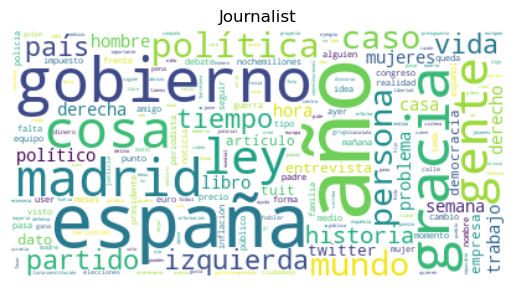

In [29]:
journalist = " ".join(df[df["profession"] == "journalist"]["tweet_clean"])
show_word_cloud(journalist, "Journalist")

In [30]:
Counter(journalist.split()).most_common(10)

[('años', 428),
 ('españa', 374),
 ('gobierno', 363),
 ('gracias', 317),
 ('👇', 292),
 ('madrid', 276),
 ('ley', 273),
 ('gente', 217),
 ('año', 207),
 ('mundo', 181)]

In [65]:
journalist_tweets = df[df["profession"] == "journalist"]["tweet"]
journalist_stats = {"Group": "Journalist"}
for func, name in zip(stats, stats_name):
    journalist_stats[name] = np.sum(journalist_tweets.apply(lambda x: func(x)) / len(journalist_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(journalist_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

,Group,Fernandez Huerta,Szigriszt Pazos,Gutierrez Polini,Crawford,Tiempo de lectura
0,Journalist,79.915144,76.092235,44.653862,3.988229,1.924310
1,Female,0.000000,0.000000,0.000000,0.000000,0.000000
2,Male,78.210451,74.330711,43.963551,4.138418,2.061668
3,Male,78.210451,74.330711,43.963551,4.138418,2.061668
4,Female,78.203335,74.287509,43.927387,4.125435,2.076802


##### Celebridades

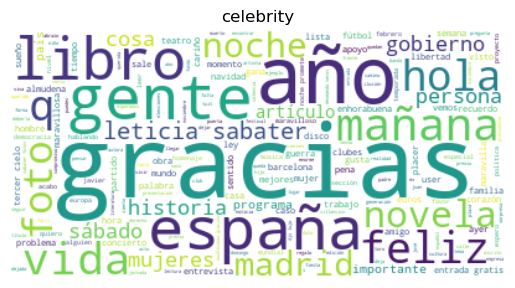

In [35]:
celebrity = " ".join(df[df["profession"] == "celebrity"]["tweet_clean"])
show_word_cloud(celebrity, "celebrity")

In [36]:
Counter(celebrity.split()).most_common(10)

[('️', 127),
 ('gracias', 107),
 ('✌', 82),
 ('🏼', 68),
 ('👇', 42),
 ('noche', 42),
 ('🙏', 41),
 ('❤', 41),
 ('años', 37),
 ('españa', 31)]

In [68]:
celebrity_tweets = df[df["profession"] == "celebrity"]["tweet"]
celebrity_stats = {"Group": "Celebrity"}
for func, name in zip(stats, stats_name):
    celebrity_stats[name] = np.sum(celebrity_tweets.apply(lambda x: func(x)) / len(celebrity_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(celebrity_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

,Group,Fernandez Huerta,Szigriszt Pazos,Gutierrez Polini,Crawford,Tiempo de lectura
0,Celebrity,82.784437,78.931344,45.665729,3.727812,1.761594
1,celebrity,82.784437,78.931344,45.665729,3.727812,1.761594
2,Journalist,82.784437,78.931344,45.665729,3.727812,1.761594
3,Journalist,79.915144,76.092235,44.653862,3.988229,1.924310
4,Female,0.000000,0.000000,0.000000,0.000000,0.000000
5,Male,78.210451,74.330711,43.963551,4.138418,2.061668
6,Male,78.210451,74.330711,43.963551,4.138418,2.061668
7,Female,78.203335,74.287509,43.927387,4.125435,2.076802


##### Políticos

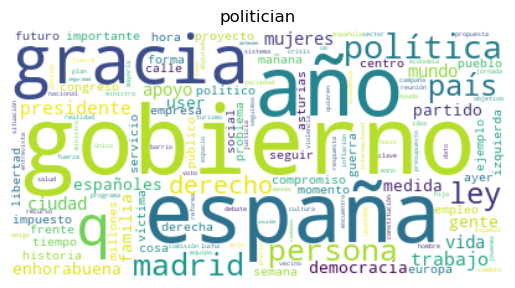

In [42]:
politician = " ".join(df[df["profession"] == "politician"]["tweet_clean"])
show_word_cloud(politician, "politician")

In [43]:
Counter(politician.split()).most_common(10)

[('gobierno', 503),
 ('españa', 392),
 ('gracias', 341),
 ('👇', 268),
 ('años', 246),
 ('️', 237),
 ('q', 230),
 ('ley', 199),
 ('madrid', 189),
 ('país', 171)]

In [69]:
politician_tweets = df[df["profession"] == "politician"]["tweet"]
politician_stats = {"Group": "Politician"}
for func, name in zip(stats, stats_name):
    politician_stats[name] = np.sum(politician_tweets.apply(lambda x: func(x)) / len(politician_tweets))
df_stats_tweets = pd.concat([pd.DataFrame(politician_stats, index=[0]), df_stats_tweets]).reset_index(drop=True)
df_stats_tweets

,Group,Fernandez Huerta,Szigriszt Pazos,Gutierrez Polini,Crawford,Tiempo de lectura
0,Politician,74.220387,70.198440,42.345898,4.478438,2.383431
1,Celebrity,82.784437,78.931344,45.665729,3.727812,1.761594
2,celebrity,82.784437,78.931344,45.665729,3.727812,1.761594
3,Journalist,82.784437,78.931344,45.665729,3.727812,1.761594
4,Journalist,79.915144,76.092235,44.653862,3.988229,1.924310
5,Female,0.000000,0.000000,0.000000,0.000000,0.000000
6,Male,78.210451,74.330711,43.963551,4.138418,2.061668
7,Male,78.210451,74.330711,43.963551,4.138418,2.061668
8,Female,78.203335,74.287509,43.927387,4.125435,2.076802


### Tweets por ideología

##### Izquierda moderada

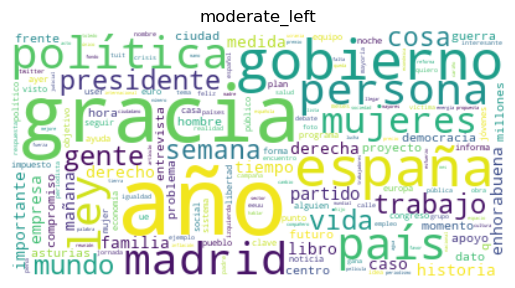

In [41]:
moderate_left = " ".join(df[df["ideology_multiclass"] == "moderate_left"]["tweet_clean"])
show_word_cloud(moderate_left, "moderate_left")

In [45]:
Counter(moderate_left.split()).most_common(10)

[('gracias', 312),
 ('años', 289),
 ('españa', 270),
 ('gobierno', 270),
 ('👇', 243),
 ('️', 214),
 ('ley', 173),
 ('país', 162),
 ('año', 155),
 ('madrid', 154)]

##### Derecha moderada

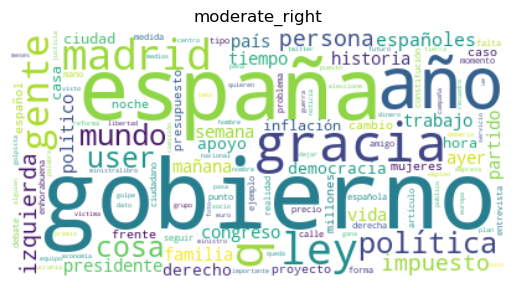

In [46]:
moderate_right = " ".join(df[df["ideology_multiclass"] == "moderate_right"]["tweet_clean"])
show_word_cloud(moderate_right, "moderate_right")

In [47]:
Counter(moderate_right.split()).most_common(10)

[('gobierno', 419),
 ('españa', 331),
 ('gracias', 244),
 ('años', 214),
 ('q', 191),
 ('ley', 187),
 ('madrid', 179),
 ('👇', 155),
 ('️', 151),
 ('gente', 122)]

##### Extrema izquierda

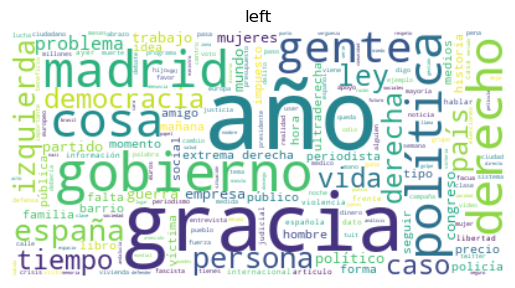

In [48]:
left = " ".join(df[df["ideology_multiclass"] == "left"]["tweet_clean"])
show_word_cloud(left, "left")

In [49]:
Counter(left.split()).most_common(10)

[('👇', 183),
 ('años', 138),
 ('gracias', 128),
 ('gobierno', 119),
 ('madrid', 111),
 ('derecha', 99),
 ('gente', 80),
 ('españa', 80),
 ('🏻', 79),
 ('ley', 78)]

##### Extrema derecha

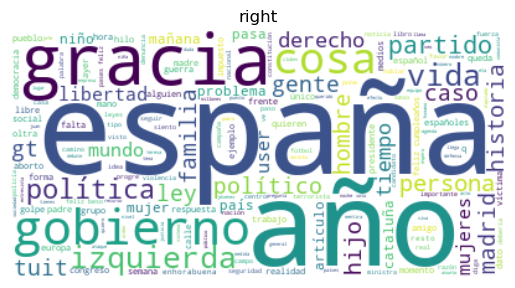

In [50]:
right = " ".join(df[df["ideology_multiclass"] == "right"]["tweet_clean"])
show_word_cloud(right, "right")

In [51]:
Counter(right.split()).most_common(10)

[('españa', 116),
 ('gracias', 81),
 ('👏', 78),
 ('gobierno', 76),
 ('años', 70),
 ('feliz', 67),
 ('️', 57),
 ('ley', 45),
 ('vida', 45),
 ('madrid', 42)]

## Preprocesado

Preprocesado para la clasificación multietiqueta:


In [7]:
from sklearn.preprocessing import LabelEncoder
df_test = pd.read_csv("../data/development_test.csv")
df_clean_multilabel_test = pd.DataFrame({})
df_clean_multilabel = pd.DataFrame({})
df_clean_multilabel["tweet"] = df["tweet"]
df_clean_multilabel_test["tweet"] = df_test["tweet"]
for label in ["gender", "profession", "ideology_binary", "ideology_multiclass"]:
    enc = LabelEncoder()
    df_clean_multilabel[label] = enc.fit_transform(df[label])
    df_clean_multilabel_test[label] = enc.transform(df_test[label])
df_clean_multilabel.to_csv("../data/multilabel_encoded.csv")
df_clean_multilabel_test.to_csv("../data/multilabel_encoded_test.csv")

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_clean_multilabel = pd.DataFrame({})
df_clean_multilabel["tweet"] = df["tweet"]
for label in ["gender", "profession", "ideology_binary", "ideology_multiclass"]:
    enc = LabelEncoder()
    df_clean_multilabel[label] = enc.fit_transform(df[label])

In [13]:
df_procesed.to_csv("../data/procesed.csv")

In [7]:
df_test = pd.read_csv("../data/development_test.csv")
df_test_processed = pd.DataFrame({})
df_test_processed["tweets"] = df_test["tweet"]
df_test_processed["labels"] = df_test["ideology_multiclass"].map({'moderate_left': 0, 'moderate_right': 1, "left": 2, "right": 3})
df_test_processed.to_csv("../data/procesed_test.csv")

## Tokenización para transformers


In [6]:
from transformers import BertTokenizer, RobertaTokenizer
from sklearn.model_selection import train_test_split

tokenizer_bert = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
tokenizer_roberta = RobertaTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_roberta_tweet(tweet):
    input_ids = tokenizer_roberta.encode(tweet)
    input_ids = [4] + input_ids + [5]
    attention_mask = [1] * len(input_ids) + [0] * (512 - len(input_ids))
    return input_ids + [0] * (512 - len(input_ids))

def tokenize_bert_tweet(tweet):
    input_ids = tokenizer_bert.encode(tweet)
    return input_ids + [0] * (512 - len(input_ids))

def input_type_ids_roberta(row):
    return [1] * len(row["roberta_ids"]) + [0] * (512 - len(row["roberta_ids"]))

def input_type_ids_bert(row):
    return [1] * len(row["bert_ids"]) + [0] * (512 - len(row["bert_ids"]))

def prepare_datasets():
    df = pd.read_csv("../data/multilabel_encoded.csv", index_col=0)
    df_test = pd.read_csv("../data/multilabel_encoded_test.csv", index_col=0)
    df["roberta_ids"] = df["tweet"].apply(tokenize_roberta_tweet)
    df["bert_ids"] = df["tweet"].apply(tokenize_bert_tweet)
    df["roberta_token_type_ids"] = [[0] * 512] * len(df)
    df["bert_token_type_ids"] = [[0] * 512] * len(df)
    df["roberta_attention_masks"] = df.apply(input_type_ids_roberta, axis=1)
    df["bert_attention_masks"] = df.apply(input_type_ids_gpt2, axis=1)
    df_train, df_val, y_train, y_val = train_test_split(
        df[['roberta_ids', 'gpt2_ids', 'roberta_token_type_ids', 'roberta_attention_masks', 'gpt2_attention_masks', 'gpt2_token_type_ids']],
        df[['gender', 'profession','ideology_binary', 'ideology_multiclass']],
        test_size=0.15,
        random_state = 100
    )
    df_train['gender'] = y_train['gender']
    df_train['profession'] = y_train['profession']
    df_train['ideology_binary'] = y_train['ideology_binary']
    df_train['ideology_multiclass'] = y_train['ideology_multiclass']
    df_val['gender'] = y_val['gender']
    df_val['profession'] = y_val['profession']
    df_val['ideology_binary'] = y_val['ideology_binary']
    df_val['ideology_multiclass'] = y_val['ideology_multiclass']
    df_train.to_pickle("./train_bert.pickle")
    df_val.to_pickle("./validation_bert.pickle")
    df_test["roberta_ids"] = df_test["tweet"].apply(tokenize_roberta_tweet)
    df_test["bert_ids"] = df_test["tweet"].apply(tokenize_gpt_tweet)
    df_test["roberta_token_type_ids"] = [[0] * 512] * len(df_test)
    df_test["bert_token_type_ids"] = [[0] * 512] * len(df_test)
    df_test["roberta_attention_masks"] = df_test.apply(input_type_ids_roberta, axis=1)
    df_test["bert_attention_masks"] = df_test.apply(input_type_ids_gpt2, axis=1)
    df_test.drop('tweet', axis=1)
    df_test.to_pickle("./test_bert.pickle")
prepare_datasets()

OSError: Can't load tokenizer for 'xlm-roberta-base'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'xlm-roberta-base' is the correct path to a directory containing all relevant files for a RobertaTokenizer tokenizer.

### Dataset para el test

In [76]:
df_test = pd.read_csv("../data/multilabel_encoded.csv", index_col=0)
df_test["ideology_multiclass"]

array([0, 3, 2, 1], dtype=int64)